In [1]:
%matplotlib inline

import pickle

from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

/home/qkt/.local/share/virtualenvs/sgan-techniques-WxACZbr4/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sns.set_style('whitegrid')

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [4]:
def dense_discriminator(x, is_training, num_classes=10, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x, 512, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, 256, activation=tf.nn.leaky_relu)
        features = tf.layers.dense(x, 128, activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(features, num_classes + 1)
        output = tf.nn.softmax(logits)
        return output, logits, features

In [5]:
def dense_generator(x, is_training, output_shape=(28, 28, 1), reuse=False):
    with tf.variable_scope('generator', reuse=reuse) as scope:
        x = tf.layers.dense(x, 256, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, 512, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, np.prod(output_shape), activation=tf.nn.tanh)
        x = tf.reshape(x, (-1,) + output_shape)
        
        return x

In [6]:
def build_dense_model(x_real, z, is_training, num_classes=10, output_shape=(28, 28, 1)):
    d_real_prob, d_real_logits, d_real_features = dense_discriminator(
        x_real, is_training, num_classes=num_classes, reuse=False,
    )
    x_fake = dense_generator(z, is_training, output_shape=output_shape)
    d_fake_prob, d_fake_logits, d_fake_features = dense_discriminator(
        x_fake, is_training, num_classes=num_classes, reuse=True,
    )
    return d_real_prob, d_real_logits, d_real_features, d_fake_prob, d_fake_logits, d_fake_features, x_fake

In [7]:
def standard_loss_accuracy(d_real_prob, d_real_logits, d_real_features,
                           d_fake_prob, d_fake_logits, d_fake_features,
                           extended_label, labeled_mask):
    epsilon = 1e-8
    
    ### Discriminator loss
    # Supervised loss for discriminator
    d_ce = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_real_logits,
                                                      labels=extended_label)
    d_loss_supervised = tf.reduce_sum(labeled_mask * d_ce) / (tf.reduce_sum(labeled_mask) + epsilon)
    # Unsupervised loss for discriminator
    # data is real
    # subtract from one due to log --> log of (1 - 0) is 0, therefore loss is 0 for d_real_prob[i, -1] == 0
    prob_real_be_real = 1 - d_real_prob[:, -1] + epsilon
    logprob = tf.log(prob_real_be_real)
    d_loss_unsupervised1 = -1 * tf.reduce_mean(logprob)
    # data is fake
    prob_fake_be_fake = d_fake_prob[:, -1] + epsilon
    logprob = tf.log(prob_fake_be_fake)
    d_loss_unsupervised2 = -1 * tf.reduce_mean(logprob)
    
    d_loss = d_loss_supervised + d_loss_unsupervised1 + d_loss_unsupervised2
    
    ### Generator loss
    # fake data is mistaken to be real
    prob_fake_be_real = 1 - d_fake_prob[:, -1] + epsilon
    logprob = tf.log(prob_fake_be_real)
    g_loss_probs = -1 * tf.reduce_mean(logprob)
    
    mean_real_features = tf.reduce_mean(d_real_features, axis=0)
    mean_fake_features = tf.reduce_mean(d_fake_features, axis=0)
    g_loss_fm = tf.reduce_mean(tf.square(mean_real_features - mean_fake_features))
    
    g_loss = g_loss_probs + g_loss_fm
    
    ### Accuracy
    correct_prediction = tf.equal(tf.argmax(d_real_prob[:, :-1], 1),
                                  tf.argmax(extended_label[:, :-1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return d_loss_supervised, d_loss_unsupervised1, d_loss_unsupervised2, d_loss, g_loss, accuracy

In [8]:
def optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate):
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in all_vars if var.name.startswith('generator')]

        d_optimizer = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        return d_optimizer, g_optimizer

In [9]:
def extend_labels(labels):
    # add extra label for fake data
    extended_label = tf.concat([labels, tf.zeros([tf.shape(labels)[0], 1])], axis=1)

    return extended_label

In [10]:
def moving_average(x, n=10):
    ret = np.cumsum(x)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
def execute(x_train, y_train, x_test, y_test,
            epochs=50000, batch_size=32, test_steps=500, num_labeled_examples=None, 
            periodic_labeled_batch=False, periodic_labeled_batch_frequency=10,
            x_height=28, x_width=28, num_channels=1, latent_size=100):
    tf.reset_default_graph()
    
    num_classes = np.unique(y_train).shape[0]
    y_test = to_categorical(y_test, num_classes=num_classes)
    
    x = tf.placeholder(tf.float32, name='x', shape=(None, x_height, x_width, num_channels))
    label = tf.placeholder(tf.float32, name='label', shape=(None, num_classes))
    labeled_mask = tf.placeholder(tf.float32, name='labeled_mask', shape=(None,))
    z = tf.placeholder(tf.float32, name='z', shape=(None, latent_size))
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    g_learning_rate = tf.placeholder(tf.float32, name='g_learning_rate')
    d_learning_rate = tf.placeholder(tf.float32, name='d_learning_rate')
    
    model = build_dense_model(x, z, is_training)
    extended_label = extend_labels(label)
    d_real_prob, d_real_logits, d_real_features, d_fake_prob, d_fake_logits, d_fake_features, x_fake = model
    loss_acc = standard_loss_accuracy(d_real_prob, d_real_logits, d_real_features,
                                      d_fake_prob, d_fake_logits, d_fake_features,
                                      extended_label, labeled_mask)
    _, _, _, d_loss, g_loss, accuracy = loss_acc
    d_optimizer, g_optimizer = optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate)
    
    if num_labeled_examples is None:
        global_mask = np.ones(x_train.shape[0])
        periodic_labeled_batch = False
    else:
        global_mask = np.zeros(x_train.shape[0])
        for cls in np.unique(y_train):
            idx = y_train == cls
            idx = np.random.choice(np.flatnonzero(idx), num_labeled_examples // num_classes, replace=False)
            global_mask[idx] = 1.0
        
    
    train_d_losses, train_g_losses, train_accuracies = [], [], []
    test_d_losses, test_g_losses, test_accuracies = [], [], []
    
    def test_gan(epoch):
        d_batch_losses, g_batch_losses, batch_accuracies = [], [], []
        
        test_size = x_test.shape[0]
        batch_size = test_size // 100
        test_mask = np.ones(test_size)
        for i in range(0, test_size, batch_size):
            z_test = np.random.normal(0, 1, (batch_size, latent_size))
            test_mask = np.ones(test_size)
            test_dictionary = {
                x: x_test[i:i+batch_size],
                z: z_test,
                label: y_test[i:i+batch_size],
                labeled_mask: test_mask[i:i+batch_size],
                is_training: False
            }

            test_d_loss = d_loss.eval(feed_dict=test_dictionary)
            test_g_loss = g_loss.eval(feed_dict=test_dictionary)
            test_accuracy = accuracy.eval(feed_dict=test_dictionary)
            
            d_batch_losses.append(test_d_loss)
            g_batch_losses.append(test_g_loss)
            batch_accuracies.append(test_accuracy)

        test_d_loss = np.mean(d_batch_losses)
        test_g_loss = np.mean(g_batch_losses)
        test_accuracy = np.mean(batch_accuracies)
        
        test_d_losses.append(test_d_loss)
        test_g_losses.append(test_g_loss)
        test_accuracies.append(test_accuracy)

        print(epoch, test_d_loss, test_g_loss, test_accuracy)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            if periodic_labeled_batch and epoch % periodic_labeled_batch_frequency == 0:
                idx = np.flatnonzero(global_mask)
                x_batch = x_train[idx]
                y_batch = y_train[idx]
                mask = global_mask[idx]
                z_batch = np.random.normal(0, 1, (len(idx), latent_size))
                
                x_batches = [x_batch[i:i+batch_size] for i in range(0, len(x_batch), batch_size)]
                y_batches = [y_batch[i:i+batch_size] for i in range(0, len(y_batch), batch_size)]
                masks = [mask[i:i+batch_size] for i in range(0, len(mask), batch_size)]
                z_batches = [z_batch[i:i+batch_size] for i in range(0, len(z_batch), batch_size)]    
            else:
                idx = np.random.randint(0, x_train.shape[0], batch_size)
                x_batch = x_train[idx]
                y_batch = y_train[idx]
                mask = global_mask[idx]
                z_batch = np.random.normal(0, 1, (batch_size, latent_size))
                
                x_batches = [x_batch]
                y_batches = [y_batch]
                masks = [mask]
                z_batches = [z_batch]
            
            train_d_loss_batches, train_g_loss_batches, train_accuracy_batches = [], [], []
            for x_batch, y_batch, mask, z_batch in zip(x_batches, y_batches, masks, z_batches):
                y_batch = to_categorical(y_batch, num_classes=num_classes)
                train_dictionary = {
                    x: x_batch,
                    z: z_batch,
                    label: y_batch,
                    labeled_mask: mask,
                    g_learning_rate: 0.001,
                    d_learning_rate: 0.001,
                    is_training: True
                }
                d_optimizer.run(feed_dict=train_dictionary)
                g_optimizer.run(feed_dict=train_dictionary)

                train_d_loss = d_loss.eval(feed_dict=train_dictionary)
                train_g_loss = g_loss.eval(feed_dict=train_dictionary)
                train_accuracy = accuracy.eval(feed_dict=train_dictionary)
                
                train_d_loss_batches.append(train_d_loss)
                train_g_loss_batches.append(train_g_loss)
                train_accuracy_batches.append(train_accuracy)
            
            train_d_losses.append(np.mean(train_d_loss_batches))
            train_g_losses.append(np.mean(train_g_loss_batches))
            train_accuracies.append(np.mean(train_accuracy_batches))
            
            if epoch % test_steps == 0:
                test_gan(epoch)
        test_gan(epochs)
    
    return train_d_losses, train_g_losses, train_accuracies, test_d_losses, test_g_losses, test_accuracies

In [12]:
def run_test(output_file, num_labeled_examples=None,
             periodic_labeled_batch=False, periodic_labeled_batch_frequency=10):
    results = execute(x_train, y_train, x_test, y_test, num_labeled_examples=num_labeled_examples,
                      periodic_labeled_batch=periodic_labeled_batch,
                      periodic_labeled_batch_frequency=periodic_labeled_batch_frequency)
    train_d_losses, train_g_losses, train_accuracies, test_d_losses, test_g_losses, test_accuracies = results
    with open(output_file, 'wb') as f:
        pickle.dump({
            'train_d_losses': train_d_losses,
            'train_g_losses': train_g_losses,
            'train_accuracies': train_accuracies,
            'test_d_losses': test_d_losses,
            'test_g_losses': test_g_losses,
            'test_accuracies': test_accuracies
        }, f)
    return results

In [13]:
def plot_losses(results):
    train_d_losses, train_g_losses, _, test_d_losses, test_g_losses, _ = results
    
    average_train_d_losses = moving_average(train_d_losses, 10)
    average_train_g_losses = moving_average(train_g_losses, 10)

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(average_train_d_losses)), average_train_d_losses, label='discriminator training loss')
    plt.plot(np.arange(len(average_train_g_losses)), average_train_g_losses, label='generator training loss')
    plt.plot(np.arange(len(test_d_losses)) * 500, test_d_losses, label='discriminator test loss')
    plt.plot(np.arange(len(test_g_losses)) * 500, test_g_losses, label='generator test loss')
    plt.legend()

In [14]:
def plot_accuracies(results):
    _, _, train_accuracies, _, _, test_accuracies = results
    
    average_train_accuracies = moving_average(train_accuracies, 10)

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(average_train_accuracies)), average_train_accuracies, label='training accuracy')
    plt.plot(np.arange(len(test_accuracies)) * 500, test_accuracies, label='test accuracy')
    plt.legend()

In [15]:
results = run_test('improved-gan-all.pkl')

0 5.6618285 0.6415392 0.1308
500 0.52267176 3.988471 0.90720004
1000 0.4692218 6.1091027 0.9242
1500 0.66874754 4.2130632 0.9286
2000 0.47414088 4.388212 0.9389
2500 0.48064712 6.700485 0.9431999
3000 0.48289734 4.901989 0.9398
3500 1.318056 1.4196925 0.9499
4000 0.81014407 4.285251 0.94589996
4500 0.79242384 3.2359495 0.95619994
5000 1.0921797 2.1383276 0.95699996
5500 0.904708 2.8879218 0.95170003
6000 1.5225302 1.8560078 0.9537999
6500 1.4319243 1.6354225 0.9534999
7000 1.2629839 2.5958064 0.9604
7500 2.0231366 3.6701527 0.9591
8000 1.5525689 1.698858 0.9631001
8500 1.3810216 1.5615238 0.96389997
9000 1.4117324 1.9318821 0.9568
9500 1.2686478 2.1000612 0.96779996
10000 1.3376688 2.004398 0.96129996
10500 1.3446646 1.8957703 0.96650004
11000 1.526953 1.4694786 0.9589001
11500 1.3070265 1.938863 0.96520007
12000 1.5511757 1.5253198 0.96549994
12500 1.8478793 1.838642 0.97020006
13000 1.5843179 1.6341205 0.9685001
13500 1.487116 1.6896639 0.9663001
14000 1.6667256 2.0883796 0.96849996


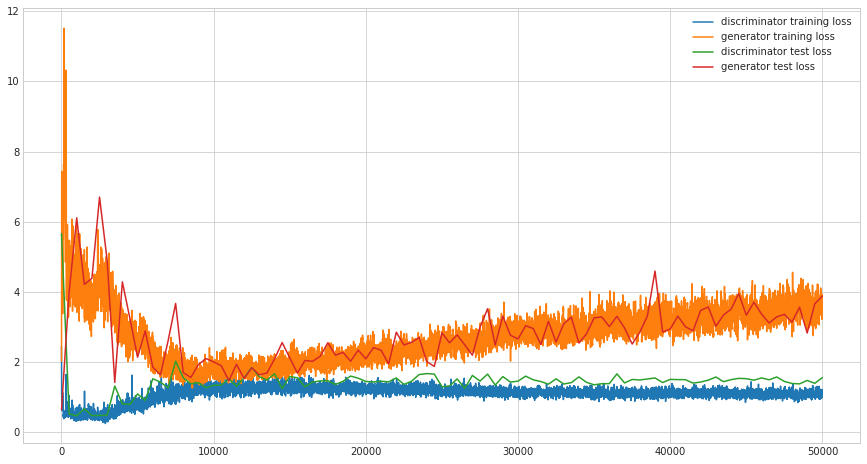

In [16]:
plot_losses(results)

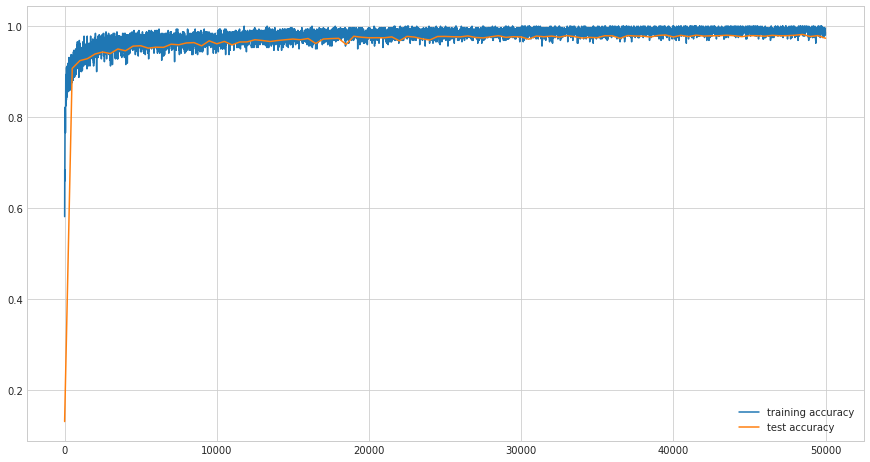

In [17]:
plot_accuracies(results)

In [18]:
results = run_test('improved-gan-100.pkl', num_labeled_examples=100)

0 4.673553 0.34688905 0.0794
500 3.1566663 6.2202473 0.0961
1000 3.6017275 6.304007 0.1535
1500 3.1882648 1.8370697 0.1258
2000 4.2992268 7.8489275 0.1665
2500 2.7312782 3.627859 0.3049
3000 3.3323689 11.975795 0.3536
3500 3.6291513 2.0578897 0.2782
4000 1.9630079 3.389931 0.4362
4500 2.981028 3.972069 0.34520003
5000 2.4201028 3.6261728 0.48699996
5500 3.8681846 6.041397 0.44409996
6000 3.200507 8.714797 0.4615
6500 3.014343 7.462932 0.4334
7000 2.7664442 3.5321205 0.48210004
7500 6.6631584 5.132752 0.36269996
8000 2.955233 7.8507915 0.5221
8500 2.0484443 3.3600214 0.5778
9000 3.0012927 5.823556 0.49610004
9500 4.1548676 3.8371768 0.42310002
10000 2.3850844 3.0694132 0.5755999
10500 2.8884113 3.4259858 0.5414
11000 3.1116035 4.397095 0.5985
11500 2.5440323 5.054121 0.53349996
12000 5.1346154 2.4078188 0.28620002
12500 3.91444 4.5321226 0.3884
13000 2.8684201 5.427896 0.6003
13500 2.1772337 3.157473 0.6072
14000 4.709492 2.643409 0.35429996
14500 4.6204214 2.5877295 0.3561
15000 4.1199

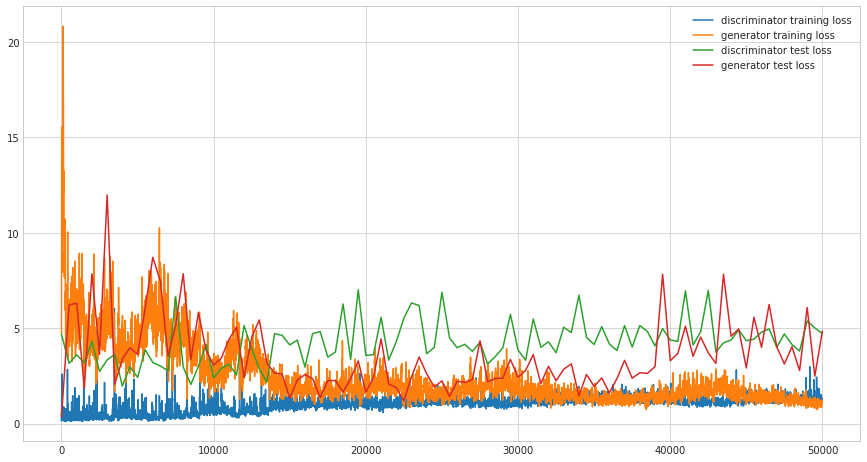

In [19]:
plot_losses(results)

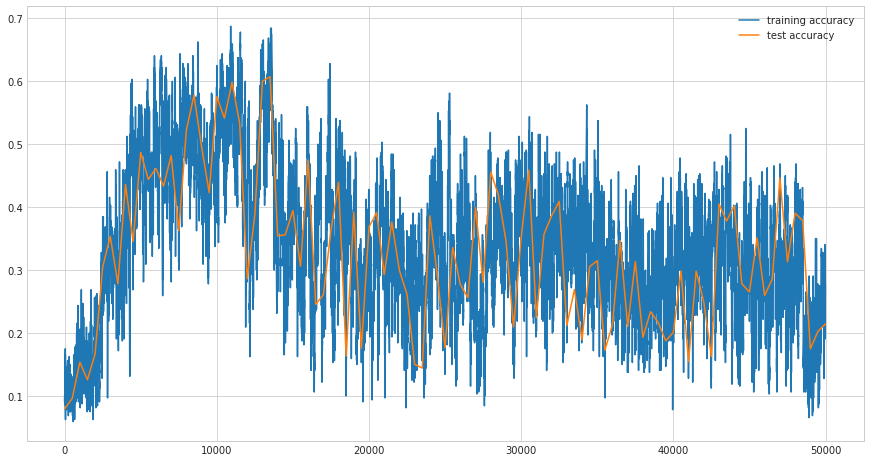

In [20]:
plot_accuracies(results)

In [21]:
results = run_test('improved-gan-100-periodic.pkl', num_labeled_examples=100, periodic_labeled_batch=True)

0 3.4169 0.7253372 0.21880001
500 1.6379062 4.921838 0.7579
1000 1.6787525 1.6652712 0.7547
1500 3.4492545 6.06669 0.7364
2000 2.754374 5.3630867 0.78129995
2500 2.9615183 5.49665 0.77900004
3000 1.7797456 3.216862 0.82359993
3500 2.784805 4.3462276 0.8035
4000 1.8004211 2.0503254 0.8316
4500 2.1464553 3.2913938 0.7891001
5000 1.9545482 3.2786448 0.84520006
5500 4.5003095 4.9316196 0.81350017
6000 1.8906043 1.8705351 0.8626001
6500 2.6737401 3.330655 0.83339995
7000 3.0122232 3.456688 0.81820005
7500 2.5281577 2.5002122 0.8620001
8000 3.2908814 3.287188 0.8780999
8500 1.9451118 1.9865085 0.8897999
9000 2.6691837 2.6783917 0.8674
9500 2.8294742 2.7755125 0.8997
10000 2.5396707 2.5011864 0.8851
10500 2.218753 2.1439362 0.90739995
11000 2.404384 3.1131158 0.91850007
11500 2.4074206 3.233173 0.90879995
12000 2.716117 3.150451 0.8741
12500 1.9811679 2.3866465 0.92130005
13000 2.736581 3.0111642 0.87970006
13500 1.9510311 2.539546 0.9146
14000 2.1145108 2.8389382 0.9256
14500 2.0864046 2.358

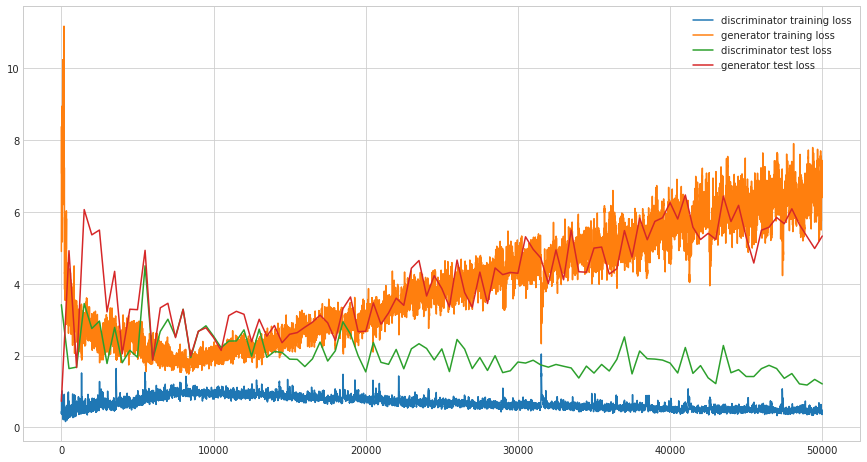

In [22]:
plot_losses(results)

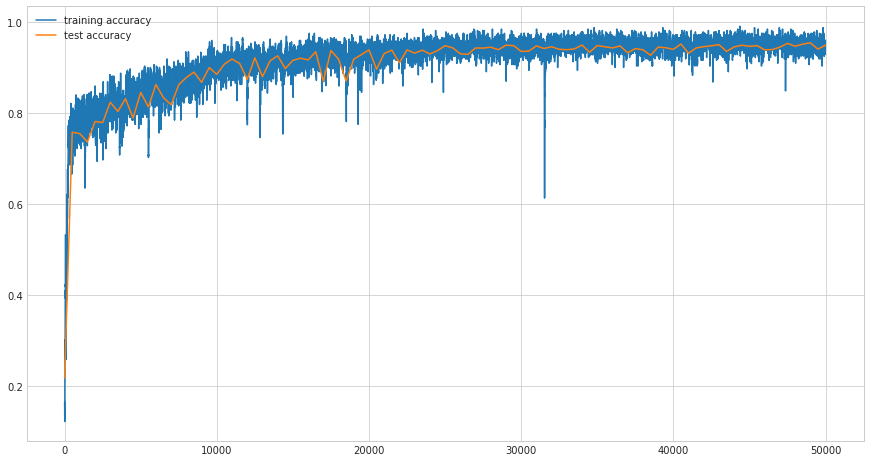

In [23]:
plot_accuracies(results)

In [24]:
results = run_test('improved-gan-300-periodic.pkl', num_labeled_examples=300, periodic_labeled_batch=True)

0 2.3227537 1.7259134 0.33200002
500 1.0833044 4.6996546 0.8079
1000 1.3692398 6.6975274 0.8492999
1500 1.5066932 3.7563567 0.8016999
2000 3.7318954 7.7810555 0.84669995
2500 2.79643 5.493548 0.82310015
3000 1.8247311 3.5031807 0.8668
3500 2.0232983 3.7305014 0.8545
4000 3.4292297 3.1273966 0.8278
4500 2.666806 2.9902816 0.86389995
5000 2.8080878 2.5235584 0.86429995
5500 2.3821154 2.3019347 0.88069993
6000 3.0269756 2.3753746 0.85550004
6500 3.8169863 3.170613 0.7979001
7000 3.027735 2.3865714 0.8669
7500 3.6057904 2.7732062 0.8484999
8000 3.5301895 2.675788 0.8499
8500 3.1903803 2.3442779 0.82839996
9000 3.2173321 2.874209 0.8241
9500 3.3858967 3.0803244 0.8426001
10000 3.3657894 2.457474 0.78900003
10500 3.1884375 2.6378706 0.8139
11000 2.8601458 2.6732912 0.8603
11500 3.2153442 2.8029196 0.8536001
12000 3.0724955 2.994595 0.88449997
12500 3.251005 2.6822176 0.85620004
13000 3.004266 3.2917466 0.8358
13500 2.8208294 3.0989802 0.8687999
14000 3.093625 2.5982778 0.8346999
14500 3.3482

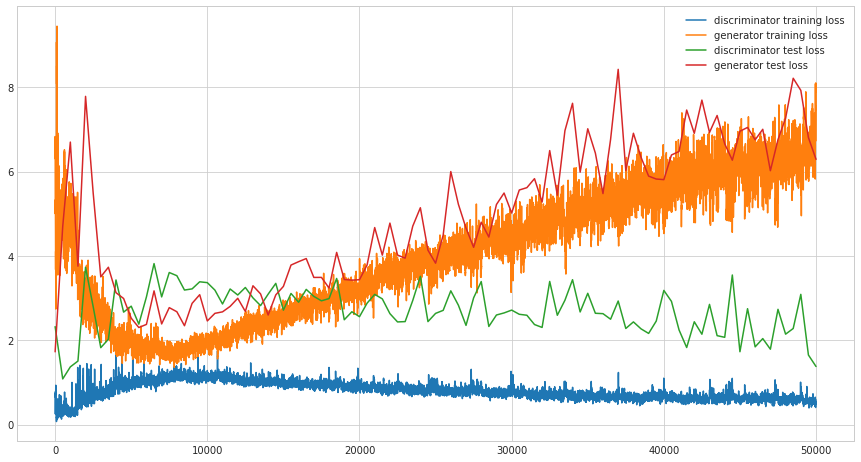

In [25]:
plot_losses(results)

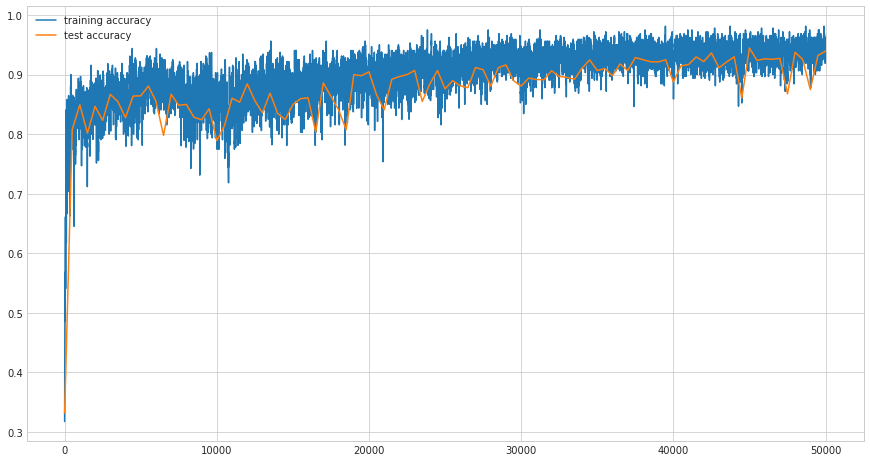

In [26]:
plot_accuracies(results)

In [27]:
results = run_test('improved-gan-500-periodic.pkl', num_labeled_examples=500, periodic_labeled_batch=True)

0 1.7283235 2.141241 0.59339994
500 1.1253613 3.7612467 0.8554001
1000 1.7083223 4.9184217 0.8667
1500 1.480745 2.964229 0.87799996
2000 1.7374051 2.2633193 0.87250006
2500 1.9854671 2.429389 0.88260007
3000 4.1181235 4.5269136 0.8891999
3500 2.452506 2.386459 0.8748999
4000 2.8641257 2.8031492 0.88049996
4500 3.0045993 2.907119 0.88499993
5000 3.0260088 2.7714417 0.8906999
5500 2.94086 3.046776 0.8889
6000 3.5459704 3.058768 0.8905999
6500 3.5187027 3.0207922 0.8958
7000 3.480597 2.795611 0.8870999
7500 3.144331 2.4340022 0.87179995
8000 3.1918364 3.0685394 0.8793
8500 3.608987 2.8201065 0.7965001
9000 3.5589447 2.7733772 0.78400004
9500 3.5886996 2.418591 0.6892
10000 4.3377438 2.9008331 0.6477001
10500 4.4566207 3.109135 0.6363
11000 4.054765 2.7961907 0.6799
11500 4.157128 3.2208982 0.6933
12000 4.4876075 3.3175 0.5851
12500 3.9314573 3.5161862 0.741
13000 4.557987 3.6645384 0.62590003
13500 5.0685425 3.820985 0.5944
14000 4.007244 3.8148263 0.6841
14500 4.2081304 3.5400393 0.64699

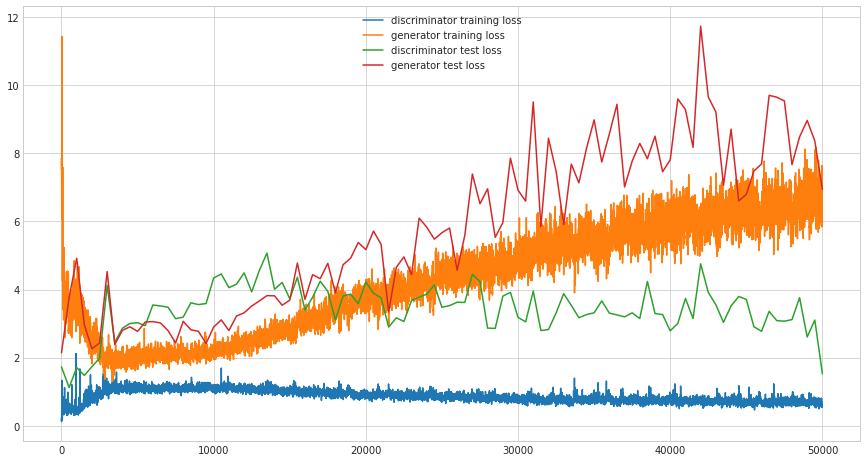

In [28]:
plot_losses(results)

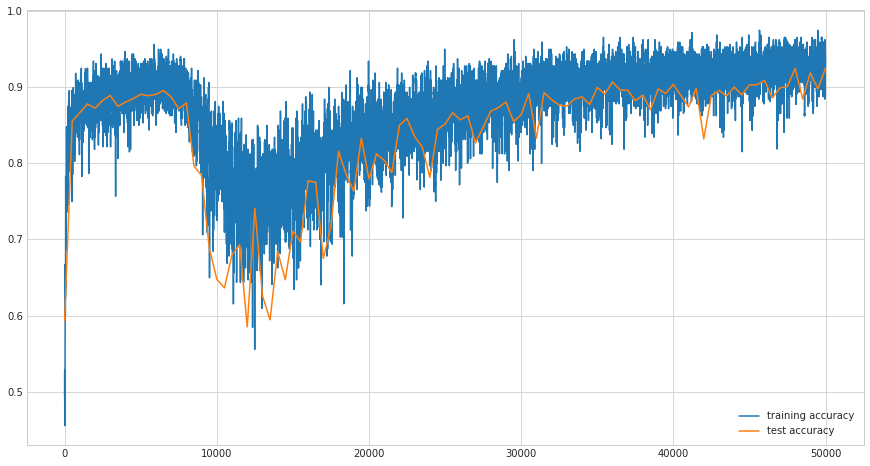

In [29]:
plot_accuracies(results)

In [30]:
results = run_test('improved-gan-1000-periodic.pkl', num_labeled_examples=1000, periodic_labeled_batch=True)

0 2.8935513 1.3152957 0.6941999
500 0.8457971 5.8582067 0.9043
1000 1.151959 3.4655068 0.9093999
1500 1.9936484 1.7358162 0.9137999
2000 1.7207739 2.6260724 0.9298001
2500 1.9433031 2.2789953 0.9222
3000 2.7456129 2.595906 0.9209999
3500 2.7188418 2.724437 0.9198
4000 3.4224267 3.714346 0.92130005
4500 3.549455 3.817315 0.93100005
5000 4.223523 4.6938643 0.90709996
5500 3.5701861 4.0404243 0.90840006
6000 3.8226442 4.225933 0.9143
6500 3.9267738 4.3965435 0.8915999
7000 3.694721 4.3929954 0.89989996
7500 3.213981 3.5667646 0.89519995
8000 3.9855313 4.435165 0.89239997
8500 3.951601 4.5876975 0.8794
9000 4.2106876 4.7776055 0.8937
9500 3.8718624 4.515075 0.87609994
10000 4.342514 5.577025 0.8589
10500 4.3643565 6.4314375 0.878
11000 4.0459228 4.9392457 0.88030005
11500 3.8188424 5.372524 0.88859993
12000 4.1741242 5.652089 0.8814
12500 4.276289 5.345778 0.88
13000 3.7239957 5.5870943 0.88799995
13500 3.9025705 5.898676 0.88629997
14000 4.5213075 6.320404 0.86269987
14500 4.71819 6.05491

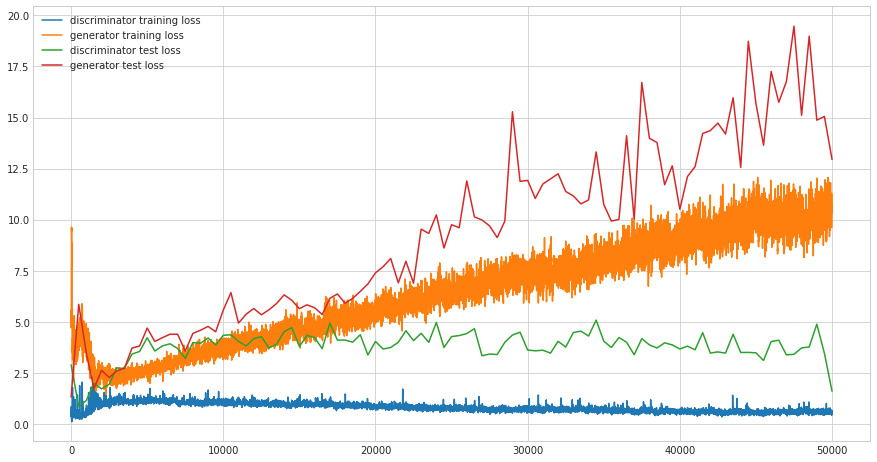

In [31]:
plot_losses(results)

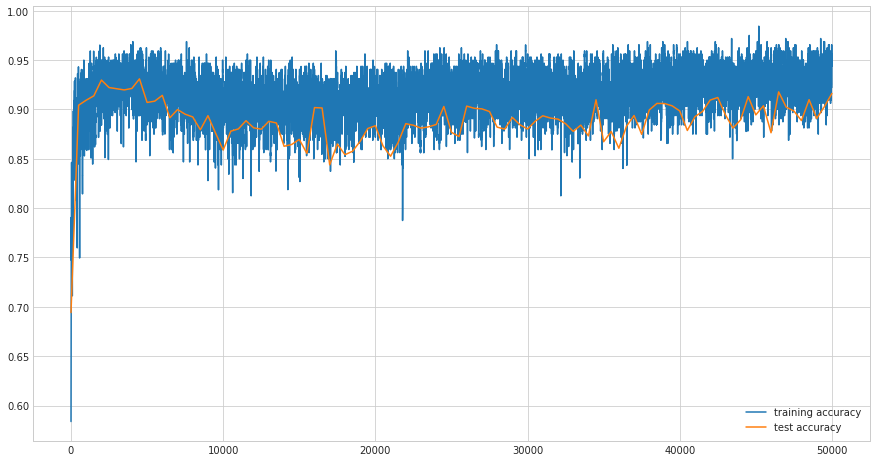

In [32]:
plot_accuracies(results)